In [43]:
from pathlib import Path
from analytics.app.data.load import list_pipelines
from analytics.app.data.transform import dfs_models_and_evals
from analytics.app.data.transform import patch_yearbook_time
from analytics.app.data.transform import logs_dataframe
from analytics.app.data.transform import df_aggregate_eval_metric
from analytics.app.data.transform import logs_dataframe_agg_by_stage
from modyn.supervisor.internal.grpc.enums import PipelineStage


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

from analytics.plotting.common.common import SAVE_PLOT

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
# INPUTS

pipelines_dir = Path(
    "/Users/mboether/phd/dynamic-data/sigmod-data/yearbook/data_selection_50%/logs_agg_patch"
)
output_dir = Path(
    "/Users/mboether/phd/dynamic-data/dynamic_datasets_dsl/analytics/plotting/sigmod"
)
assert pipelines_dir.exists()
assert output_dir.exists()

In [45]:
pipelines = list_pipelines(pipelines_dir)
max_pipeline_id = max(pipelines.keys())
pipelines

{5: ('yearbook_yearbooknet_full_nosched_epoch5_warm2',
  PosixPath('pipeline_5')),
 11: ('yearbook_yearbooknet_grad_bts_nosched_epoch5_warm2',
  PosixPath('pipeline_11')),
 16: ('yearbook_yearbooknet_uniform_nosched_epoch5_warm2',
  PosixPath('pipeline_16')),
 17: ('yearbook_yearbooknet_classb_nosched_epoch5_warm2',
  PosixPath('pipeline_17')),
 18: ('yearbook_yearbooknet_rs2wo_nosched_epoch5_warm2',
  PosixPath('pipeline_18')),
 25: ('yearbook_yearbooknet_margin_bts_nosched_epoch5_warm2',
  PosixPath('pipeline_25')),
 32: ('yearbook_yearbooknet_rs2w_nosched_epoch5_warm2_r500',
  PosixPath('pipeline_32')),
 33: ('yearbook_yearbooknet_entropy_bts_nosched_epoch5_warm2_r500',
  PosixPath('pipeline_33')),
 44: ('yearbook_yearbooknet_loss_bts_nosched_epoch5_warm2_r500',
  PosixPath('pipeline_44')),
 45: ('yearbook_yearbooknet_lc_bts_nosched_epoch5_warm2_r500',
  PosixPath('pipeline_45'))}

In [46]:
from analytics.app.data.load import load_pipeline_logs


pipeline_logs = {
    p_id: load_pipeline_logs(p_id, pipelines_dir)
    for (p_id, (_, p_path)) in pipelines.items()
}

In [47]:
type(pipeline_logs[32])

modyn.supervisor.internal.pipeline_executor.models.PipelineLogs

In [48]:
def map_pipeline_names(pipeline_ref: str) -> str:
    stripped = re.sub(
            "_nosched.*",
            "",
            (
                pipeline_ref\
                .removeprefix("yearbook_yearbooknet_")\
                .removeprefix("cglm_")
            ),
    )
    return {
        "full": "Full",
        "rs2wo": "RS2 (w/o)",
        "grad_bts": "DLIS",
        "margin_bts": "Margin",
        "lc_bts": "Least conf.",
        "entropy_bts": "Entropy",
        "rs2w": "RS2",
        "classb": "Class-Bal.",
        "uniform": "Uniform",
        "loss_bts": "Loss",
    }.get(stripped, stripped) + " "

In [49]:
pipeline_ids = [p_id for p_id, (p, _) in pipelines.items()]
composite_model_variant = "currently_trained_model"  # currently_trained_model
patch_yearbook = True
dataset_id = "yearbook_test"
eval_handler = "slidingmatrix"
metric = "Accuracy"

pipelines = {
    int(k): (
        map_pipeline_names(v[0]), v[1]
    ) 
    for k, v in pipelines.items()
    if not (v[0].endswith("_r125") or v[0].endswith("_r250"))
}

[
    (p_id, pname) for p_id, (pname, _) in pipelines.items()
    if p_id in pipeline_ids
]

[(5, 'Full '),
 (11, 'DLIS '),
 (16, 'Uniform '),
 (17, 'Class-Bal. '),
 (18, 'RS2 (w/o) '),
 (25, 'Margin '),
 (32, 'RS2 '),
 (33, 'Entropy '),
 (44, 'Loss '),
 (45, 'Least conf. ')]

# Wrangle data

In [50]:
list_df_eval_single: list[pd.DataFrame] = []
list_of_timing_dfs: list[pd.DataFrame] = []

for pipeline_id in pipeline_ids:
    df_all = logs_dataframe(pipeline_logs[pipeline_id], pipelines[pipeline_id][0])
    list_of_timing_dfs.append(df_all.groupby(["pipeline_ref"]).agg(cost=("duration", "sum")).reset_index())

    _, _, df_eval_single = dfs_models_and_evals(
        pipeline_logs[pipeline_id], df_all["sample_time"].max(), pipelines[pipeline_id][0]
    )
    list_df_eval_single.append(df_eval_single)

df_adjusted = pd.concat(list_df_eval_single)
df_timing = pd.concat(list_of_timing_dfs)
df_adjusted


,trigger_id,training_id,id_model,currently_active_model,currently_trained_model,eval_handler,dataset_id,interval_start,interval_end,dataset_size,metric,value,interval_center,training_idx,model_idx,pipeline_ref
0,0,0,337,False,True,slidingmatrix,yearbook_test,1970-01-01 00:00:00,1970-01-02 01:00:00,34,Accuracy,0.735294,1970-01-01 12:30:00,1,1,Full
228,57,204,540,False,False,slidingmatrix,yearbook_test,1970-01-01 00:00:00,1970-01-02 01:00:00,34,Accuracy,0.647059,1970-01-01 12:30:00,58,58,Full
227,56,200,537,False,False,slidingmatrix,yearbook_test,1970-01-01 00:00:00,1970-01-02 01:00:00,34,F1-micro,0.460784,1970-01-01 12:30:00,57,57,Full
226,56,200,537,False,False,slidingmatrix,yearbook_test,1970-01-01 00:00:00,1970-01-02 01:00:00,34,F1-macro,0.458097,1970-01-01 12:30:00,57,57,Full
225,56,200,537,False,False,slidingmatrix,yearbook_test,1970-01-01 00:00:00,1970-01-02 01:00:00,34,F1-weighted,0.440498,1970-01-01 12:30:00,57,57,Full
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28331,26,698,3723,False,False,slidingmatrix,yearbook_test,1970-03-24 23:00:00,1970-03-27 01:00:00,51,F1-micro,0.758170,1970-03-26 00:00:00,27,27,Least conf.
28330,26,698,3723,False,False,slidingmatrix,yearbook_test,1970-03-24 23:00:00,1970-03-27 01:00:00,51,F1-macro,0.723222,1970-03-26 00:00:00,27,27,Least conf.
28329,26,698,3723,False,False,slidingmatrix,yearbook_test,1970-03-24 23:00:00,1970-03-27 01:00:00,51,F1-weighted,0.740504,1970-03-26 00:00:00,27,27,Least conf.
28337,28,700,3725,False,False,slidingmatrix,yearbook_test,1970-03-24 23:00:00,1970-03-27 01:00:00,51,F1-weighted,0.714824,1970-03-26 00:00:00,29,29,Least conf.


In [51]:
df_timing

,pipeline_ref,cost
0,Full,298139.781536
0,DLIS,297891.627444
0,Uniform,305436.440978
0,Class-Bal.,306922.029473
0,RS2 (w/o),330934.303420
0,Margin,300479.370562
0,RS2,330666.405674
0,Entropy,300047.270497
0,Loss,314666.989429
0,Least conf.,315882.490865


In [52]:
df_adjusted = df_adjusted[
    (df_adjusted["dataset_id"] == dataset_id)
    & (df_adjusted["eval_handler"] == eval_handler)
    & (df_adjusted["metric"] == metric)
]

# in percent (0-100)
df_adjusted["value"] = df_adjusted["value"] * 100
df_adjusted

,trigger_id,training_id,id_model,currently_active_model,currently_trained_model,eval_handler,dataset_id,interval_start,interval_end,dataset_size,metric,value,interval_center,training_idx,model_idx,pipeline_ref
0,0,0,337,False,True,slidingmatrix,yearbook_test,1970-01-01 00:00:00,1970-01-02 01:00:00,34,Accuracy,73.529410,1970-01-01 12:30:00,1,1,Full
228,57,204,540,False,False,slidingmatrix,yearbook_test,1970-01-01 00:00:00,1970-01-02 01:00:00,34,Accuracy,64.705882,1970-01-01 12:30:00,58,58,Full
224,56,200,537,False,False,slidingmatrix,yearbook_test,1970-01-01 00:00:00,1970-01-02 01:00:00,34,Accuracy,46.078432,1970-01-01 12:30:00,57,57,Full
220,55,198,534,False,False,slidingmatrix,yearbook_test,1970-01-01 00:00:00,1970-01-02 01:00:00,34,Accuracy,67.647060,1970-01-01 12:30:00,56,56,Full
216,54,196,531,False,False,slidingmatrix,yearbook_test,1970-01-01 00:00:00,1970-01-02 01:00:00,34,Accuracy,78.431374,1970-01-01 12:30:00,55,55,Full
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28328,26,698,3723,False,False,slidingmatrix,yearbook_test,1970-03-24 23:00:00,1970-03-27 01:00:00,51,Accuracy,75.816995,1970-03-26 00:00:00,27,27,Least conf.
28344,30,702,3727,False,False,slidingmatrix,yearbook_test,1970-03-24 23:00:00,1970-03-27 01:00:00,51,Accuracy,77.124184,1970-03-26 00:00:00,31,31,Least conf.
28340,29,701,3726,False,False,slidingmatrix,yearbook_test,1970-03-24 23:00:00,1970-03-27 01:00:00,51,Accuracy,75.816995,1970-03-26 00:00:00,30,30,Least conf.
28336,28,700,3725,False,False,slidingmatrix,yearbook_test,1970-03-24 23:00:00,1970-03-27 01:00:00,51,Accuracy,73.202616,1970-03-26 00:00:00,29,29,Least conf.


In [53]:
if patch_yearbook:
    for column in ["interval_start", "interval_center", "interval_end"]:
        patch_yearbook_time(df_adjusted, column)
    patch_yearbook_time(df_all, "sample_time")

In [54]:
df_adjusted = df_adjusted.sort_values(by=["interval_center"])

In [55]:
# Reduce to composite models
df_adjusted = df_adjusted[df_adjusted[composite_model_variant]]
df_adjusted[composite_model_variant].unique()

array([ True])

# Dump Data backup

# Create Plot

In [56]:
# reduce evaluation interval to interval where all policies have evaluations
min_active_eval_center_per_pipeline = df_adjusted[
    df_adjusted[composite_model_variant]
].groupby("pipeline_ref")["interval_center"].min()
maximum_min = min_active_eval_center_per_pipeline.max()
print(maximum_min, min_active_eval_center_per_pipeline)

df_adjusted = df_adjusted[
    df_adjusted["interval_center"] >= maximum_min
]
df_adjusted["interval_center"].unique() 

1930-07-10 02:30:00 pipeline_ref
Class-Bal.     1930-07-10 02:30:00
DLIS           1930-07-10 02:30:00
Entropy        1930-07-10 02:30:00
Full           1930-07-10 02:30:00
Least conf.    1930-07-10 02:30:00
Loss           1930-07-10 02:30:00
Margin         1930-07-10 02:30:00
RS2            1930-07-10 02:30:00
RS2 (w/o)      1930-07-10 02:30:00
Uniform        1930-07-10 02:30:00
Name: interval_center, dtype: datetime64[ns]


<DatetimeArray>
['1930-07-10 02:30:00', '1931-01-08 14:30:00', '1932-01-01 00:00:00',
 '1933-01-01 00:00:00', '1934-01-01 00:00:00', '1935-01-01 00:00:00',
 '1936-01-01 00:00:00', '1937-01-01 00:00:00', '1938-01-01 00:00:00',
 '1939-01-01 00:00:00', '1940-01-01 00:00:00', '1941-01-01 00:00:00',
 '1942-01-01 00:00:00', '1943-01-01 00:00:00', '1944-01-01 00:00:00',
 '1945-01-01 00:00:00', '1946-01-01 00:00:00', '1947-01-01 00:00:00',
 '1948-01-01 00:00:00', '1949-01-01 00:00:00', '1950-01-01 00:00:00',
 '1951-01-01 00:00:00', '1952-01-01 00:00:00', '1953-01-01 00:00:00',
 '1954-01-01 00:00:00', '1955-01-01 00:00:00', '1956-01-01 00:00:00',
 '1957-01-01 00:00:00', '1958-01-01 00:00:00', '1959-01-01 00:00:00',
 '1960-01-01 00:00:00', '1961-01-01 00:00:00', '1962-01-01 00:00:00',
 '1963-01-01 00:00:00', '1964-01-01 00:00:00', '1965-01-01 00:00:00',
 '1966-01-01 00:00:00', '1967-01-01 00:00:00', '1968-01-01 00:00:00',
 '1969-01-01 00:00:00', '1970-01-01 00:00:00', '1971-01-01 00:00:00',
 '19

In [57]:
df_adjusted["interval_center"] = df_adjusted["interval_center"].astype(str).str.split("-").str[0]


In [58]:
df_adjusted[df_adjusted["pipeline_ref"].str.contains("Full")]

,trigger_id,training_id,id_model,currently_active_model,currently_trained_model,eval_handler,dataset_id,interval_start,interval_end,dataset_size,metric,value,interval_center,training_idx,model_idx,pipeline_ref
0,0,0,337,False,True,slidingmatrix,yearbook_test,1930-01-01 00:00:00,1931-01-16 05:00:00,34,Accuracy,73.529410,1930,1,1,Full
340,1,4,341,False,True,slidingmatrix,yearbook_test,1930-01-01 00:00:00,1932-01-16 05:00:00,59,Accuracy,66.101694,1931,2,2,Full
680,2,8,345,False,True,slidingmatrix,yearbook_test,1930-12-16 19:00:00,1933-01-16 05:00:00,71,Accuracy,77.464789,1932,3,3,Full
1020,3,12,347,False,True,slidingmatrix,yearbook_test,1931-12-16 19:00:00,1934-01-16 05:00:00,86,Accuracy,71.705427,1933,4,4,Full
1360,4,14,351,False,True,slidingmatrix,yearbook_test,1932-12-15 19:00:00,1935-01-16 05:00:00,111,Accuracy,76.276277,1934,5,5,Full
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27200,80,281,617,False,True,slidingmatrix,yearbook_test,2008-12-15 19:00:00,2011-01-16 05:00:00,113,Accuracy,95.280234,2010,81,81,Full
27540,81,283,619,False,True,slidingmatrix,yearbook_test,2009-12-16 19:00:00,2012-01-16 05:00:00,75,Accuracy,90.222222,2011,82,82,Full
27880,82,285,622,False,True,slidingmatrix,yearbook_test,2010-12-16 19:00:00,2013-01-16 05:00:00,72,Accuracy,93.981481,2012,83,83,Full
28220,83,288,624,False,True,slidingmatrix,yearbook_test,2011-12-16 19:00:00,2014-01-16 05:00:00,64,Accuracy,95.833333,2013,84,84,Full


In [59]:
# Aggregate metrics to a scalar value per pipeline
mean_accuracies = df_aggregate_eval_metric(
    df_adjusted,
    group_by=["pipeline_ref", "metric"],
    in_col="value",
    out_col="metric_value",
    aggregate_func="mean",
)

timing_acc_df = mean_accuracies.merge(df_timing, on="pipeline_ref")
timing_acc_df


,pipeline_ref,metric,metric_value,cost
0,Class-Bal.,Accuracy,88.236715,306922.029473
1,DLIS,Accuracy,85.934570,297891.627444
2,Entropy,Accuracy,91.427723,300047.270497
3,Full,Accuracy,92.356493,298139.781536
4,Least conf.,Accuracy,91.224957,315882.490865
5,Loss,Accuracy,83.749472,314666.989429
6,Margin,Accuracy,91.167324,300479.370562
7,RS2,Accuracy,88.425640,330666.405674
8,RS2 (w/o),Accuracy,88.797240,330934.303420
9,Uniform,Accuracy,87.811812,305436.440978


In [60]:
mean_accuracies

,pipeline_ref,metric,metric_value
0,Class-Bal.,Accuracy,88.236715
1,DLIS,Accuracy,85.934570
2,Entropy,Accuracy,91.427723
3,Full,Accuracy,92.356493
4,Least conf.,Accuracy,91.224957
5,Loss,Accuracy,83.749472
6,Margin,Accuracy,91.167324
7,RS2,Accuracy,88.425640
8,RS2 (w/o),Accuracy,88.797240
9,Uniform,Accuracy,87.811812


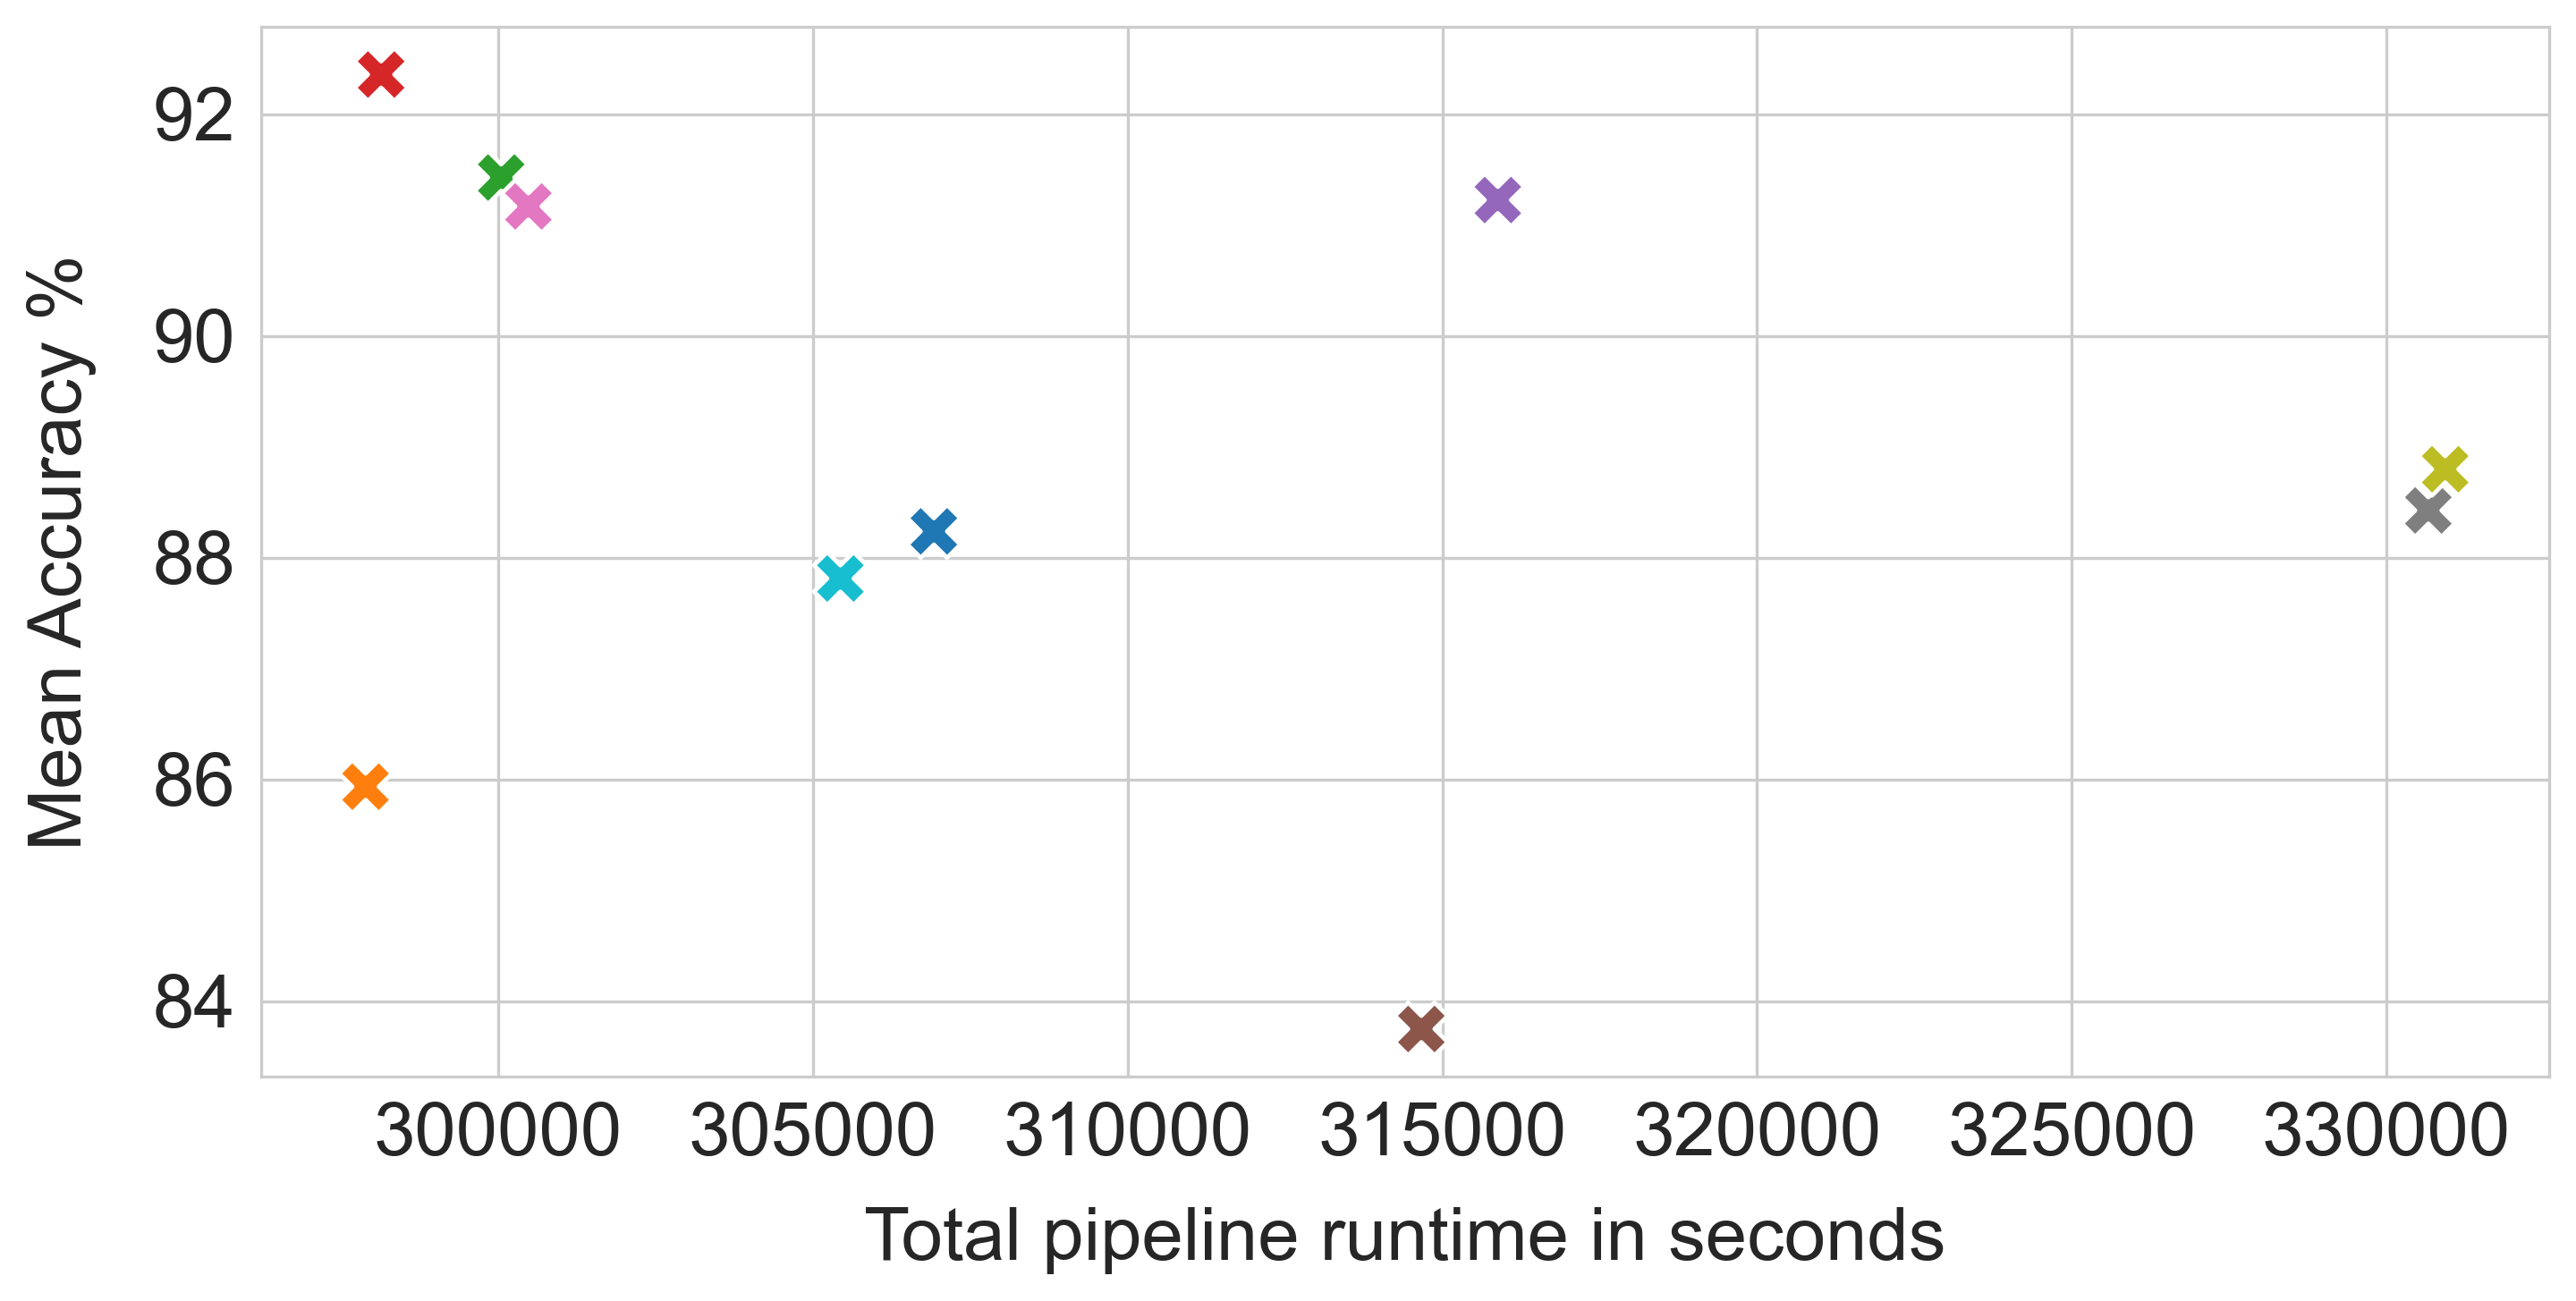

In [65]:

# Create the heatmap
from collections import defaultdict
from analytics.plotting.common.common import FIG_LEGEND, INIT_PLOT, RESIZE_TICKS


INIT_PLOT()
# sns.set_theme(style="ticks")
plt.rcParams['svg.fonttype'] = 'none'
sns.set_style("whitegrid")

FONTSIZE = 20
DOUBLE_FIG_WIDTH = 10
DOUBLE_FIG_HEIGHT = 3.5
DOUBLE_FIG_SIZE = (DOUBLE_FIG_WIDTH, 1.5 * DOUBLE_FIG_HEIGHT)

fig = plt.figure(
    edgecolor="black",
    frameon=True,
    figsize=DOUBLE_FIG_SIZE,
    dpi=300,
)

ax = sns.scatterplot(
    timing_acc_df,
    x="cost",
    y="metric_value",
    hue="pipeline_ref",
    s=200,
    legend=False,
    marker='X',
    # annotations
    
)


# Adjust x-axis tick labels
plt.xlabel("Total pipeline runtime in seconds", labelpad=10)
#plt.xticks(
#    ticks=[x for x in range(0, 80+1, 20)],
#    labels=[x for x in range(0, 80+1, 20)],
#    rotation=0,
#    # ha='right'
#)

# Set y-axis ticks to be equally spaced
plt.ylabel("Mean Accuracy %", labelpad=15)
#plt.yticks(
#    ticks=[x for x in range(86, 95+1, 3)],
#    labels=[x for x in range(86, 95+1, 3)],
#    rotation=0,
#)

# Display the plot
plt.tight_layout()
plt.show()

# Save Plot as svg

In [66]:
for img_type in ["png", "svg"]:
    img_path = output_dir / f"revision_selection_timing.{img_type}"
    fig.savefig(img_path, bbox_inches="tight", transparent=True)